# Actividad: Red Convolucional con Keras (Fashion MNIST)

En esta actividad vas a diseñar **tu propia red neuronal convolucional (CNN)** usando Keras.

## Contexto del problema

Imagina que trabajas para una **tienda online de ropa**. Cada vez que llega una nueva prenda,
el sistema hace una foto en blanco y negro y quiere **clasificar automáticamente** de qué tipo de prenda se trata:
camiseta, pantalón, vestido, abrigo, etc.

Tu misión es:

- Construir una **red convolucional** capaz de reconocer estas prendas a partir de las imágenes.
- Elegir tú mismo:
  - Cuántas capas de convolución usar.
  - Cuántos filtros y de qué tamaño.
  - Qué funciones de activación.
  - Qué optimizador, función de pérdida y métricas.
- Entrenar el modelo y **ponerlo a prueba** con ejemplos reales del conjunto de test.

Usaremos el dataset **Fashion MNIST**, que viene ya incluido en Keras.


## 1. Cargar librerías y comprobar el entorno

En esta celda importamos las librerías que vamos a usar y comprobamos que tenemos
TensorFlow y Keras disponibles.


In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.utils import plot_model

print("Python:", sys.executable)
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print(tf.config.list_physical_devices("GPU")) # Comando para confirmar si hay GPU disponibles

# Estilo de gráficos (si no existe el estilo, usamos uno básico)
try:
    plt.style.use("seaborn-v0_8")
except OSError:
    plt.style.use("seaborn")

Python: /home/juan/.pyenv/versions/3.10.13/bin/python
TensorFlow: 2.20.0-dev0+selfbuilt
Keras: 3.12.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Para que el entrenamiento de la red neuronal sea más eficiente, sería conveniente usar aceleración via GPU. Con GPUs de NVidia es más sencillo porque el soporte es más amplio (tensorflow tiene compatibilidad con CUDA por defecto), pero en mi caso tengo una GPU AMD (rx6700xt) por lo que tengo que instalar ROCm, la alternativa de AMD a CUDA, y luego deberé instalar una versión de tensorflow compatible con ROCm. He seguido esta guía https://gist.github.com/augustin-laurent/d29f026cdb53a4dff50a400c129d3ea7 y he conseguido que funcione en mi sistema.

## 2. Cargar el dataset: Fashion MNIST

Vamos a usar el conjunto de datos **Fashion MNIST**, que contiene imágenes
en escala de grises de **28×28 píxeles** de distintas prendas de ropa.

- 60.000 imágenes para entrenamiento.
- 10.000 imágenes para test.
- 10 clases (camiseta, pantalón, jersey, vestido, abrigo, sandalia, camisa, zapatilla, bolso, bota).

Primero cargamos los datos desde Keras.


In [33]:
# Carga del dataset Fashion MNIST
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = keras.datasets.fashion_mnist.load_data()

print("Tamaño de x_train:", fashion_x_train.shape)
print("Tamaño de y_train:", fashion_y_train.shape)
print("Tamaño de x_test:", fashion_x_test.shape)
print("Tamaño de y_test:", fashion_y_test.shape)

# Nombres de las clases (para visualización)
class_names = [
    "Camiseta/Top", "Pantalón", "Jersey", "Vestido",
    "Abrigo", "Sandalia", "Camisa", "Zapatilla",
    "Bolso", "Bota"
]

Tamaño de x_train: (60000, 28, 28)
Tamaño de y_train: (60000,)
Tamaño de x_test: (10000, 28, 28)
Tamaño de y_test: (10000,)


## 3. Análisis Exploratorio de Datos (EDA)

En esta sección vamos a explorar un poco el dataset antes de crear la red.

### Tareas (hazlas tú en el código de abajo):

1. **Comprobar valores mínimos y máximos** de los píxeles (deberían estar entre 0 y 255).
2. Visualizar la **distribución de clases** en `fashion_y_train` (por ejemplo, con un histograma).
3. Mostrar una cuadrícula (por ejemplo, 3×3) de imágenes de entrenamiento con su etiqueta.

> Puedes usar como referencia el EDA del cuaderno de la red totalmente conectada.


Valor mínimo en fashion_x_train: 0
Valor máximo en fashion_x_train: 255


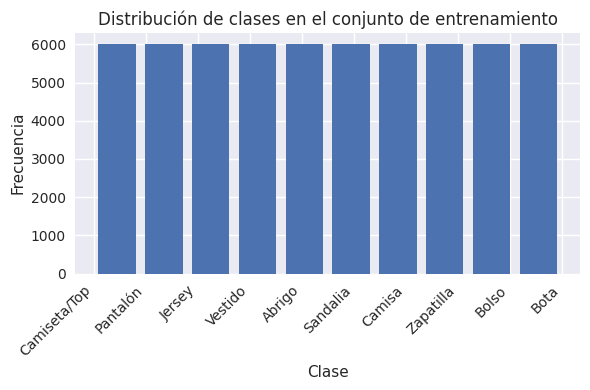

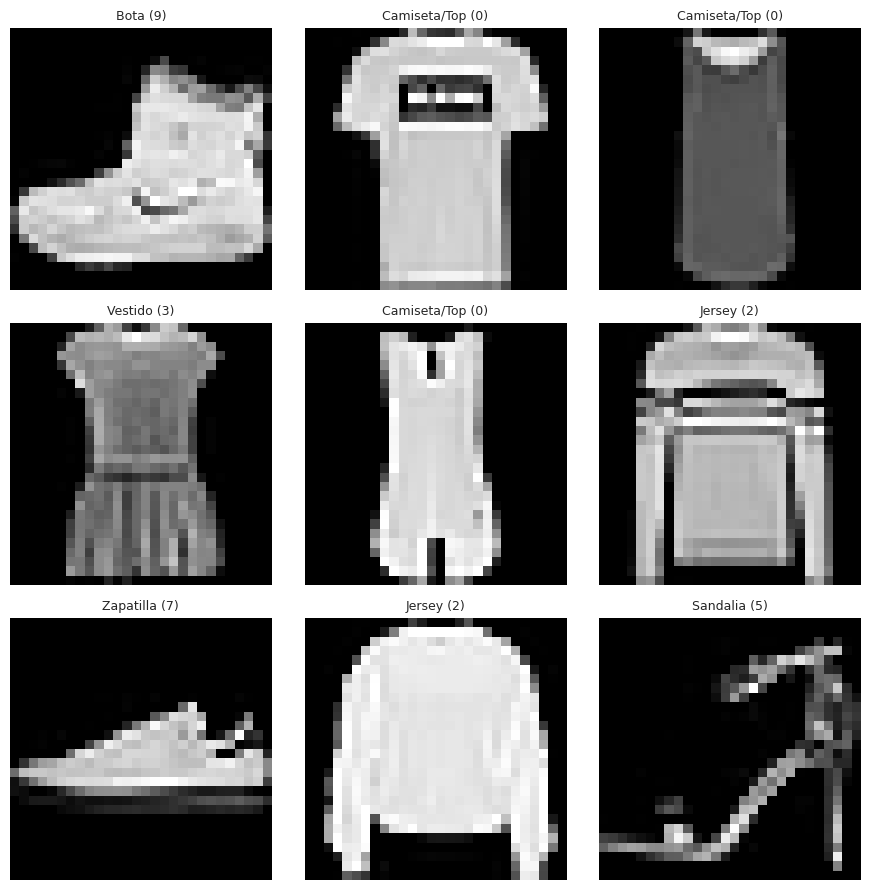

In [23]:
# 3.1: Mostrar valores mínimo y máximo de los píxeles

print("Valor mínimo en fashion_x_train:", np.min(fashion_x_train))
print("Valor máximo en fashion_x_train:", np.max(fashion_x_train))

# 3.2: Distribución de clases en el conjunto de entrenamiento

plt.figure(figsize=(6,4))
plt.hist(fashion_y_train, bins=10, rwidth=0.8)
plt.xticks(range(10), class_names, rotation=45, ha="right")
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# 3.3: Mostrar algunas imágenes de ejemplo con su etiqueta

plt.figure(figsize=(9,9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(fashion_x_train[i], cmap="gray")
    label = fashion_y_train[i]
    plt.title(f"{class_names[label]} ({label})", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

Con esta celda comprobamos que las imágenes tienen los valores mínimos y máximos correctos (0,255), que cada clase tiene el mismo número de imágenes (cada clase tiene 6000 imágenes) y vemos algunos ejemplos.

## 4. Preparar los datos para la red convolucional

Las redes convolucionales esperan las imágenes con una **dimensión de canales**.
En este caso, nuestras imágenes son de 28×28 y tienen **1 canal** (escala de grises).

Pasos:

1. **Normalizar** los píxeles a valores entre 0 y 1 dividiendo entre 255.
2. Añadir la dimensión de canales para obtener un tensor de forma `(num_imágenes, 28, 28, 1)`.
3. Crear un pequeño conjunto de **validación** a partir del conjunto de entrenamiento.


In [36]:
# 4.1: Normalización
X_train = fashion_x_train.astype("float32") / 255.0
X_test = fashion_x_test.astype("float32") / 255.0

# 4.2: Añadir dimensión de canales (escala de grises -> 1 canal)
# Forma original: (num_imágenes, 28, 28)
# Nueva forma:    (num_imágenes, 28, 28, 1)
X_train = X_train.reshape(-1, 28,28,1)
X_test = X_test.reshape(-1, 28,28,1)

print("Nueva forma de X_train:", X_train.shape)
print("Nueva forma de X_test:", X_test.shape)

# 4.3: Crear conjunto de validación (por ejemplo, las primeras 7.500 imágenes)
# (Aquí estaba la "trampa")
X_val = X_train[:7500]
y_val = fashion_y_train[:7500]

X_train_small = X_train[7500:]
y_train_small = fashion_y_train[7500:]

print("X_train_small:", X_train_small.shape)
print("X_val:", X_val.shape)

Nueva forma de X_train: (60000, 28, 28, 1)
Nueva forma de X_test: (10000, 28, 28, 1)
X_train_small: (52500, 28, 28, 1)
X_val: (7500, 28, 28, 1)


Con esta celda normalizamos, redimensionamos y creamos un conjunto de validación con 7500 imágenes del training set. en este caso el redimensionado será a una matriz de 28 por 28 con valores de 0 a 1.

## 5. Diseñar la red convolucional (ACTIVIDAD PRINCIPAL)

Ahora llega la parte importante: **tú vas a definir la red convolucional**.

### Requisitos mínimos de la red

- Usar al menos **2 capas de convolución** (`Conv2D`).
- Usar capas de **submuestreo** (`MaxPooling2D`) para reducir el tamaño de las imágenes intermedias. Fuente: https://keras.io/api/layers/pooling_layers/max_pooling2d/
- Añadir una capa `Flatten` para pasar de mapas de características 2D a un vector 1D.
- Añadir una o dos capas `Dense` finales:
  - Una capa de salida con **10 neuronas** y activación `softmax` (10 clases).

### Pistas

- Recuerda que la forma de entrada es `(28, 28, 1)`.
- Recuerda que la salida debe tener 10 neuronas porque tenemos 10 clases.

En el siguiente bloque de código tienes una plantilla. **Completa tú las capas.**


Model: "cnn_mnist_fashion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

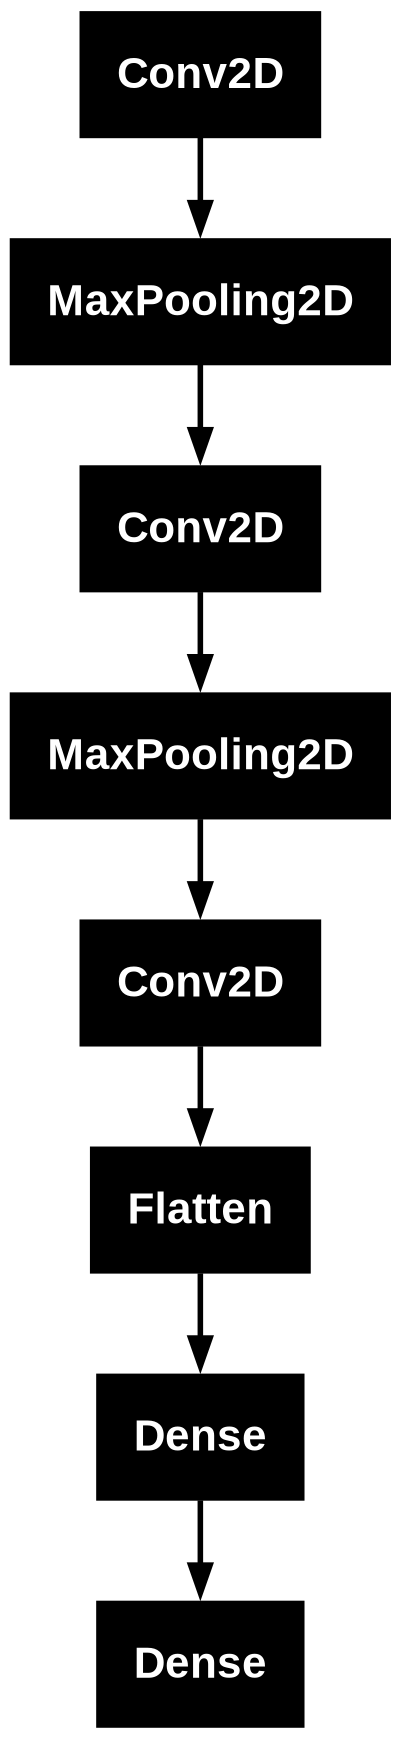

In [56]:
n_classes = 10
model = keras.Sequential(name="cnn_mnist_fashion")

# Capa de entrada

model.add(layers.Input(shape=(28, 28, 1)))

# Bloque convolucional

model.add(layers.Conv2D(32, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation="relu"))

# Bloque con capa Flatten + capas Dense para la toma de decisión final

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(n_classes, activation="softmax"))

# Al final, mostrar el resumen del modelo
model.summary()
plot_model(model)

## 6. Compilar el modelo: optimizador, función de pérdida y métricas

Ahora tienes que **compilar** tu modelo eligiendo:

- Un **optimizador**.
- Una **función de pérdida** adecuada para clasificación multiclase:
  - Normalmente: `"sparse_categorical_crossentropy"` (etiquetas 0–9 como enteros).
- Las **métricas** que quieres monitorizar.

> Recuerda la guía de la unidad 3.2: “Montando una red neuronal”.


In [57]:
# 6.1: Compilar el modelo
# COMPLETA ESTOS PARÁMETROS

optimizer_name = "adam" # En este caso, el optimizador "adam" es el que mejor resultados ofrece
loss_name = "sparse_categorical_crossentropy"  # problema de clasificación multiclase
metrics_list = ["accuracy"]

model.compile(
    optimizer=optimizer_name,
    loss=loss_name,
    metrics=metrics_list
)

## 7. Entrenar la red convolucional

Ahora vamos a entrenar tu CNN con los datos de entrenamiento.

Parámetros a elegir:

- `epochs`: cuántas veces recorre todo el conjunto de entrenamiento (por ejemplo, 5, 10, 15…).
- `batch_size`: tamaño del lote (por ejemplo, 32, 64…).

**Actividad:** elige unos valores iniciales, entrena el modelo y luego vuelve a entrenar
con otros valores para comparar resultados.


In [ ]:
# 7.1: Entrenamiento del modelo

epochs = 5
batch_size = 32

history = model.fit(
    X_train_small, y_train_small,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=1
)

# (10 epoch, 64 batch) / 52.4s
# (5 epoch, 32 batch) / 40.6s

Epoch 1/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8194 - loss: 0.4926 - val_accuracy: 0.8712 - val_loss: 0.3469
Epoch 2/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8827 - loss: 0.3180 - val_accuracy: 0.8911 - val_loss: 0.2940
Epoch 3/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9023 - loss: 0.2677 - val_accuracy: 0.9015 - val_loss: 0.2647
Epoch 4/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9131 - loss: 0.2342 - val_accuracy: 0.9039 - val_loss: 0.2638
Epoch 5/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9224 - loss: 0.2086 - val_accuracy: 0.9152 - val_loss: 0.2333


## 8. Visualizar la evolución del entrenamiento

Vamos a dibujar:

- La **pérdida** (loss) de entrenamiento y validación por epoch.
- La **accuracy** de entrenamiento y validación por epoch.

Observa si tu modelo:

- Aprende poco (las curvas se quedan altas).
- Sobreajusta (train muy bien, val empeora).


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


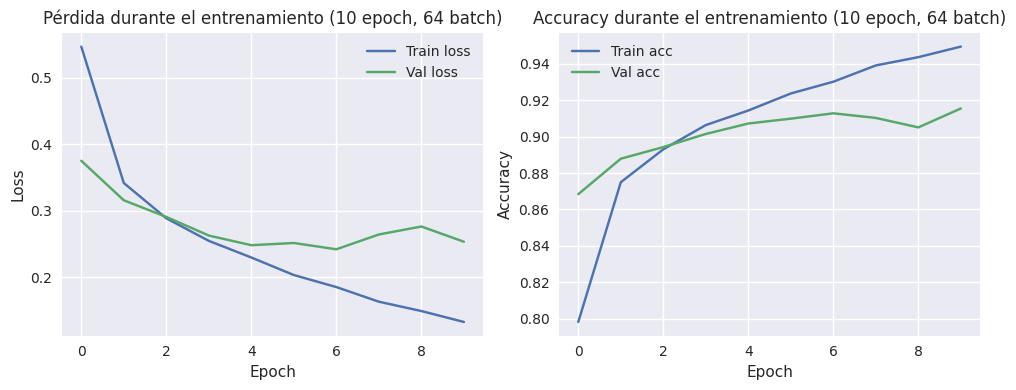

In [54]:
history_dict = history.history
print(history_dict.keys())

plt.figure(figsize=(10,4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history_dict["loss"], label="Train loss")
plt.plot(history_dict["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Pérdida durante el entrenamiento (10 epoch, 64 batch)")
plt.legend()
plt.grid(True)

# Accuracy (si existe)
if "accuracy" in history_dict:
    plt.subplot(1, 2, 2)
    plt.plot(history_dict["accuracy"], label="Train acc")
    plt.plot(history_dict["val_accuracy"], label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy durante el entrenamiento (10 epoch, 64 batch)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

En el caso de entrenar con 10 epochs y 64 de batch size, vemos que a partir del epoch 4-5 el loss de train decrece, pero el de val se estabiliza, lo que puede ser una señal de sobreajuste. Lo mismo pasa con el accuracy, el de train sigue subiendo mientras que el de val se estabiliza sobre el epoch 4, aunque sube levemente hasta el epoch 8, aún así la distancia entre train y val aumenta, lo que también es una muestra de sobreajuste.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


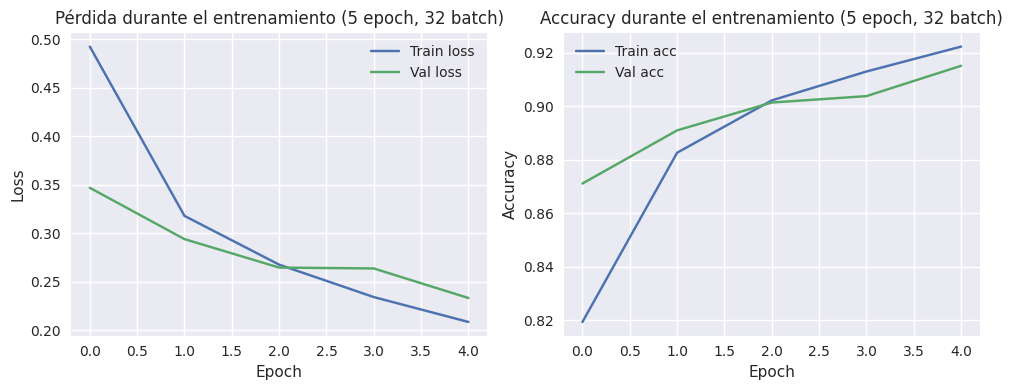

In [59]:
history_dict = history.history
print(history_dict.keys())

plt.figure(figsize=(10,4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history_dict["loss"], label="Train loss")
plt.plot(history_dict["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Pérdida durante el entrenamiento (5 epoch, 32 batch)")
plt.legend()
plt.grid(True)

# Accuracy (si existe)
if "accuracy" in history_dict:
    plt.subplot(1, 2, 2)
    plt.plot(history_dict["accuracy"], label="Train acc")
    plt.plot(history_dict["val_accuracy"], label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy durante el entrenamiento (5 epoch, 32 batch)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Aquí vemos que con 5 epochs y con 32 de batch size, el modelo no se sobreajusta tanto (la distancia entre val y train no es tan amplia)

## 9. Evaluar el modelo en el conjunto de test

Ahora vamos a evaluar tu modelo con el conjunto de test, que son datos que el modelo
**no ha visto nunca** (ni para entrenar ni para validar).

Piensa en esto como el **examen final** del modelo.


In [55]:
test_loss, test_acc = model.evaluate(X_test, fashion_y_test, verbose=0)

print(f"Pérdida en test (10 epoch, 64 batch): {test_loss:.4f}")
print(f"Accuracy en test (10 epoch, 64 batch): {test_acc:.4f}")

Pérdida en test (10 epoch, 64 batch): 0.2707
Accuracy en test (10 epoch, 64 batch): 0.9113


Conseguimos un buen accuracy (0.91), pero el loss se nos queda un poco alto (0.27)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, fashion_y_test, verbose=0)

print(f"Pérdida en test (5 epoch, 32 batch): {test_loss:.4f}")
print(f"Accuracy en test (5 epoch, 32 batch): {test_acc:.4f}")

Pérdida en test (5 epoch, 32 batch): 0.2563
Accuracy en test (5 epoch, 32 batch): 0.9095


Con 5 epochs y batch size de 32, conseguimos un accuracy y un loss muy parecidos, pero en menor tiempo.

## 10. Poner a prueba tu red con una imagen concreta

En esta sección podrás elegir **una imagen concreta** del conjunto de test y pedirle
a tu red que haga una predicción.

### Actividad

1. Cambia el valor de `idx` para elegir otra imagen.
2. Mira la imagen, la etiqueta real y la predicción.
3. Prueba varias veces con aciertos y con fallos.


Índice de la imagen: 68
Etiqueta real     => 9 (Bota)
Predicción modelo => 7 (Zapatilla)


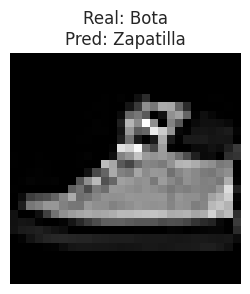

In [45]:
# Función auxiliar para probar una imagen concreta
def probar_imagen(idx):
    if idx < 0 or idx >= len(X_test):
        print(f"Índice fuera de rango. Debe estar entre 0 y {len(X_test)-1}.")
        return
    
    # Preparamos la imagen para el modelo (ya está normalizada y con canal)
    img_modelo = X_test[idx].reshape(1, 28, 28, 1)
    pred_probs = model.predict(img_modelo, verbose=0)
    pred_clase = np.argmax(pred_probs, axis=1)[0]
    true_clase = fashion_y_test[idx]

    print(f"Índice de la imagen: {idx}")
    print(f"Etiqueta real     => {true_clase} ({class_names[true_clase]})")
    print(f"Predicción modelo => {pred_clase} ({class_names[pred_clase]})")

    # Mostramos la imagen original (en escala de grises 28x28)
    plt.figure(figsize=(3,3))
    plt.imshow(fashion_x_test[idx], cmap="gray")
    plt.title(f"Real: {class_names[true_clase]}\nPred: {class_names[pred_clase]}")
    plt.axis("off")
    plt.show()

idx = 68
probar_imagen(68)
    

## Responde a las siguientes preguntas usando texto y, si lo ves útil, capturas de tus gráficas/resultados.

1. **Forma de las curvas de entrenamiento**
   - Observa las gráficas de *loss* y *accuracy* (train vs validation).
   - ¿Tu modelo parece **infrentrenado** (underfitting), **sobreajustado** (overfitting) o razonablemente equilibrado?  
   - Justifica tu respuesta usando lo que ves en las curvas (por ejemplo: se separan mucho, se quedan muy altas, etc.).
		- Con las pruebas que he realizado puedo concluir que, con la arquitectura utilizada, alcanzaremos un modelo relativamente equilibrado alrededor de los 5 epochs. Si elegimos más epochs, por ejemplo 10, veremos que el loss de train sigue bajando y el accuracy sigue subiendo, pero en la parte de validación, se estabiliza y aumenta su distancia con train, lo que podría significar un sobreajuste.

2. **Análisis del resultado en test**
   - ¿Qué valor de *accuracy en test* has obtenido?  
		- Pérdida en test (5 epoch, 32 batch): 0.2563
		- Accuracy en test (5 epoch, 32 batch): 0.9095

3. **Interpretación de la arquitectura**
   Explica con tus palabras (sin tecnicismos excesivos, ni IA Generativa) qué aporta cada bloque principal de tu red:
   - Capas **Convolucionales**: ¿qué “trabajo” hacen sobre la imagen?
		- Las capas convolucionales van filtrando el input con una especie de "ventana" que revisa todo el input y extrae o filtra patrones importantes. Las primeras capas extraen información simple como líneas o gradientes y a medida que añadimos más capas convolucionales, cada capa es capaz de extraer patrones más complejos. Las capas MaxPooling2D intermedias "comprimen" la imagen sin que se pierda mucha información.
   - Capa **Flatten**: ¿para qué sirve en el flujo de datos?
		- La capa Flatten que está entre el bloque convolucional y el bloque de capas Dense, sirve para que la información extraida por el bloque convolucional se pueda usar en la toma de decisiones de la capa dense. Básicamente, esta capa convierte las matrices extraídas en un vector muy largo que se le pueda ser usado por una capa Dense.
   - Capas **Dense** finales: ¿qué papel juegan en la decisión de la clase?
		- Las capas Dense son las que realmente hacen el "razonamiento" y toman la decisión final. Nuestra red tiene 2 capas dense, una intermedia con 128 nodos y una final con 10 nodos, uno por cada clase.

4. **Mejoras posibles del modelo**
   Imagina que tienes que **mejorar el modelo sin cambiar de dataset**. Propón al menos **dos cambios** que probarías y explica por qué podrían ayudar.
   - 1. Podríamos aplicar data augmentation (rotar las imágenes, hacer zoom, etc...). Esto ayudaría a reconocer las imágenes aunque no estén 100% alineadas.
   - 2. También podríamos añadir más capas convolucionales para que nuestra red pueda reconocer patrones aún más complejo. El inconveniente es que mientras más capas, más costoso es de entrenar e inferir.

5. **Reflexión sobre train / validation / test**
   - ¿Por qué no es buena idea usar solo **train y test** sin conjunto de validación cuando estamos ajustando hiperparámetros?
		- No es buena idea usar solo train y test porque acabarías ajustando el modelo para que funcione bien solo con los datos de test y no con datos reales nunca vistos. El conjunto de validación sirve para probar ajustes de hiperparámetros sin "contaminar" el test, que debe quedar como una prueba final del rendimiento real del modelo.